<a href="https://colab.research.google.com/github/olley102/CommunityDetectionURSS/blob/main/autoencoder_image_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoencoder image segmentation
This is an attempt to implement an idea to use autoencoders to encode local spatial information of images to then apply clustering.

## 1. Sliding window autoencoder

In [1]:
!git clone https://github.com/olley102/CommunityDetectionURSS.git

Cloning into 'CommunityDetectionURSS'...
remote: Enumerating objects: 130, done.
remote: Counting objects: 100% (130/130), done.
remote: Compressing objects: 100% (102/102), done.
remote: Total 130 (delta 55), reused 76 (delta 22), pack-reused 0
Receiving objects: 100% (130/130), 2.34 MiB | 10.19 MiB/s, done.
Resolving deltas: 100% (55/55), done.


In [2]:
import sys
sys.path.append('/content/CommunityDetectionURSS')

In [3]:
from image_processing import nn

## 2. GPWv411 Population Count dataset

In [4]:
!pip install rasterio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.3 MB 1.2 MB/s 


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
!ls '/content/drive/My Drive/GoogleEarthEngine'

GPW_v411_pc_time0.tif  GPW_v411_pc_time2.tif  GPW_v411_pc_time4.tif
GPW_v411_pc_time1.tif  GPW_v411_pc_time3.tif


In [7]:
import rasterio

In [8]:
import numpy as np

In [9]:
with rasterio.open('/content/drive/My Drive/GoogleEarthEngine/GPW_v411_pc_time0.tif', 'r') as ds:
  time0 = ds.read()

gpw = np.zeros((time0.shape[1], time0.shape[2], 5), dtype='float')
gpw[..., 0] = time0[0]

for i in range(4):
  with rasterio.open(f'/content/drive/My Drive/GoogleEarthEngine/GPW_v411_pc_time{i+1}.tif', 'r') as ds:
    gpw[..., i+1] = ds.read()[0]

gpw[np.isnan(gpw)] = 0.0

In [10]:
from image_processing import optical_flow

In [11]:
uv = optical_flow.iteration(gpw, 1, alpha=10, use_previous=True, centering=(0, 0, 0))

In [12]:
image0 = np.dstack((gpw[..., 0], np.moveaxis(uv[..., 0], 0, -1)))

In [13]:
image0.shape

(1796, 1105, 3)

## 3. Apply WindowAE

In [14]:
ae = nn.WindowAE(window_size=(7, 7), num_channels=3, encoder_sizes=(49, 3), decoder_sizes=(49, 245))

In [15]:
ae.make()
ae.compile()

In [ ]:
# !mkdir /content/checkpoints

In [16]:
fp = '/content/checkpoints/checkpoint_{epoch}.hdf5'
ae.make_callback(fp, period=10)

In [17]:
ae.model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 7, 7, 5)]         0         
                                                                 
 flatten (Flatten)           (None, 245)               0         
                                                                 
 dense (Dense)               (None, 49)                12054     
                                                                 
 dense_1 (Dense)             (None, 3)                 150       
                                                                 
 dense_2 (Dense)             (None, 49)                196       
                                                                 
 dense_3 (Dense)             (None, 245)               12250     
                                                                 
 reshape (Reshape)           (None, 7, 7, 5)           0     

In [18]:
ae.encoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 7, 7, 5)]         0         
                                                                 
 flatten (Flatten)           (None, 245)               0         
                                                                 
 dense (Dense)               (None, 49)                12054     
                                                                 
 dense_1 (Dense)             (None, 3)                 150       
                                                                 
 activation (Activation)     (None, 3)                 0         
                                                                 
Total params: 12,204
Trainable params: 12,204
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = ae.fit(image0, image0, epochs=1500, batch_size=1000)

In [19]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'mse')

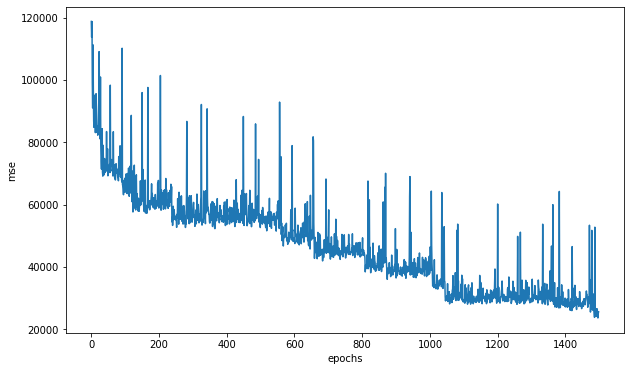

In [ ]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot()
history_arr = [h.history['loss'][0] for h in history]
ax.plot(history_arr[1:])
ax.set_xlabel('epochs')
ax.set_ylabel('mse')

Stagnation at about 1050 epochs, but lowest at end so no need to restore any previous epochs.

In [ ]:
# !cp /content/checkpoints/checkpoint_1500.hdf5 /content/drive/My\ Drive/Colab\ Notebooks/Files/checkpoint_1500.hdf5

In [20]:
ae.load_epoch('/content/drive/My Drive/Colab Notebooks/Files/checkpoint_{epoch}.hdf5', 1500)

True

In [22]:
encoding = ae.encode(image0, verbose=True, batch_size=image0.shape[1]*10)

Encoding pixels 0:11050
346/346 [==============================] - 0s 1ms/step
Encoding pixels 11050:22100
346/346 [==============================] - 0s 1ms/step
Encoding pixels 22100:33150
346/346 [==============================] - 0s 1ms/step
Encoding pixels 33150:44200
346/346 [==============================] - 0s 1ms/step
Encoding pixels 44200:55250
346/346 [==============================] - 0s 1ms/step
Encoding pixels 55250:66300
346/346 [==============================] - 0s 1ms/step
Encoding pixels 66300:77350
346/346 [==============================] - 0s 1ms/step
Encoding pixels 77350:88400
346/346 [==============================] - 0s 1ms/step
Encoding pixels 88400:99450
346/346 [==============================] - 0s 1ms/step
Encoding pixels 99450:110500
346/346 [==============================] - 0s 1ms/step
Encoding pixels 110500:121550
346/346 [==============================] - 0s 1ms/step
Encoding pixels 121550:132600
346/346 [==============================] - 0s 1ms/step
Enc

In [24]:
pred = ae.predict(image0, verbose=True, batch_size=image0.shape[1]*100)

Predicting pixels 0:110500
3454/3454 [==============================] - 5s 1ms/step
Predicting pixels 110500:221000
3454/3454 [==============================] - 5s 1ms/step
Predicting pixels 221000:331500
3454/3454 [==============================] - 5s 1ms/step
Predicting pixels 331500:442000
3454/3454 [==============================] - 5s 1ms/step
Predicting pixels 442000:552500
3454/3454 [==============================] - 5s 1ms/step
Predicting pixels 552500:663000
3454/3454 [==============================] - 5s 1ms/step
Predicting pixels 663000:773500
3454/3454 [==============================] - 5s 1ms/step
Predicting pixels 773500:884000
3454/3454 [==============================] - 5s 1ms/step
Predicting pixels 884000:994500
3454/3454 [==============================] - 5s 1ms/step
Predicting pixels 994500:1105000
3454/3454 [==============================] - 6s 2ms/step
Predicting pixels 1105000:1215500
3454/3454 [==============================] - 5s 1ms/step
Predicting pixels 12155

In [25]:
pred.shape

(1796, 1105, 3)

In [30]:
np.any(pred)

False

Text(0.5, 1.0, 'Prediction')

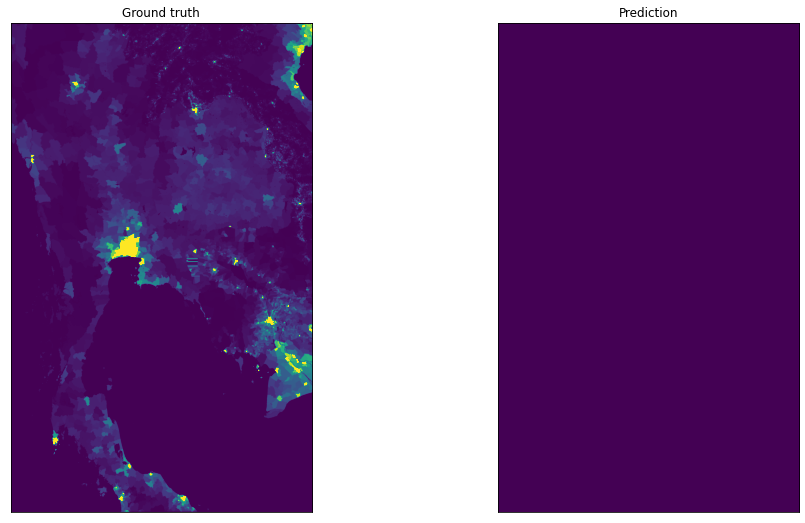

In [27]:
fig = plt.figure(figsize=(16, 9))
ax1 = fig.add_subplot(121)
im1 = ax1.imshow(gpw[..., i], vmin=0, vmax=1000)
ax1.xaxis.set_visible(False)
ax1.yaxis.set_visible(False)
ax1.set_title('Ground truth')

ax2 = fig.add_subplot(122)
im2 = ax2.imshow(pred[..., 0], vmin=0, vmax=1000)
ax2.xaxis.set_visible(False)
ax2.yaxis.set_visible(False)
ax2.set_title('Prediction')

In [31]:
np.any(encoding)

True

In [32]:
encoding.shape

(1796, 1105, 3)

In [35]:
np.max(encoding)

49664.91015625

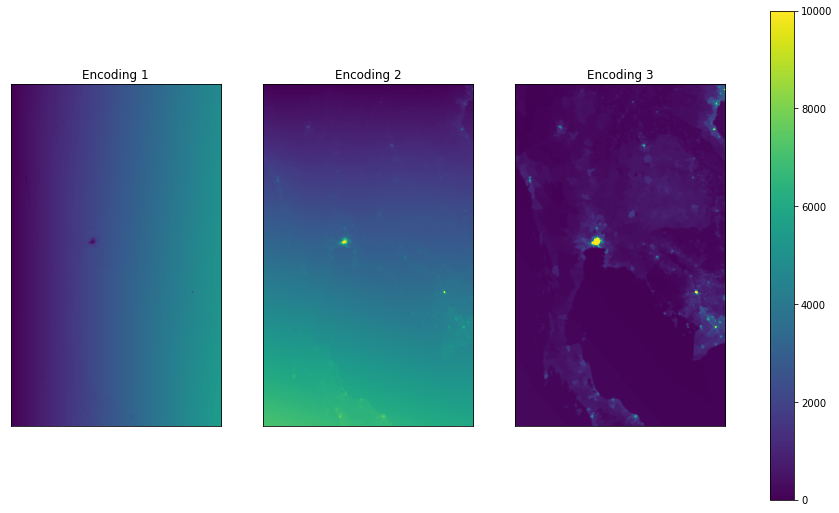

In [49]:
fig = plt.figure(figsize=(16, 9))
axes = []

for i in range(3):
  ax = fig.add_subplot(1, 3, i+1)
  im = ax.imshow(encoding[..., i], vmin=0, vmax=10000)
  ax.xaxis.set_visible(False)
  ax.yaxis.set_visible(False)
  ax.set_title(f'Encoding {i+1}')
  axes.append(ax)

fig.colorbar(im, ax=axes)